## Phantom

In [ ]:
import numpy as np
import cv2

# --- Parametri dell'immagine e dell'ottagono ---
L = 4000      # dimensione dell'immagine
radius = 1000 # raggio ottagono piccolo
radius2 = 2000 # raggio ottagono medio
radius3 = 1900 # raggio ottagono interno
fade_width = 200  # larghezza sfumatura esterna
fade_width2 = 1  # larghezza sfumatura interna (non usato qui, rimosso per chiarezza)

# Crea un'immagine nera
image = np.zeros((L, L), dtype=np.uint8)

# Funzione per calcolare i vertici dell'ottagono
def calculate_octagon_points(center, radius, num_sides=8, angle_offset=np.pi / 8):
    return np.array([
        [int(center[0] + radius * np.cos(2 * np.pi * i / num_sides + angle_offset)),
         int(center[1] + radius * np.sin(2 * np.pi * i / num_sides + angle_offset))]
        for i in range(num_sides)
    ], np.int32).reshape((-1, 1, 2))

# Calcola i vertici dei tre ottagoni
center = (L // 2, L // 2)
points = calculate_octagon_points(center, radius)
points2 = calculate_octagon_points(center, radius2)
points3 = calculate_octagon_points(center, radius3)

# --- Genera la maschera con sfumatura ---
mask = np.zeros_like(image, dtype=np.uint8)
cv2.fillPoly(mask, [points], 255)  # ottagono piccolo bianco

distance_transform = cv2.distanceTransform(255 - mask, cv2.DIST_L2, 5)
normalized = np.clip(1 - (distance_transform / fade_width), 0, 1) * 255
faded_octagon = normalized.astype(np.uint8)

# --- Disegna ottagoni grigi e neri concentrici ---
cv2.fillPoly(image, [points2], 255)  # ottagono medio bianco
cv2.fillPoly(image, [points3], 0)    # ottagono interno nero

# Sovrapponi la sfumatura all'immagine
image = np.maximum(image, faded_octagon)

# --- Aggiungi rumore gaussiano ---
mean, sigma = 0, 1
gaussian_noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
image = cv2.add(image, gaussian_noise)

# Salva l'immagine
cv2.imwrite("octagon_with_fade.jpg", image)

# --- Visualizzazione sicura (gestione chiusura e blocchi) ---
cv2.imshow("Ottagono con Sfumatura", image)
print("Premi un tasto qualsiasi per chiudere la finestra o ESC per uscire...")

while True:
    key = cv2.waitKey(100) & 0xFF
    # Se premi ESC (27) o chiudi la finestra, esci
    if key == 27 or cv2.getWindowProperty("Ottagono con Sfumatura", cv2.WND_PROP_VISIBLE) < 1:
        break

cv2.destroyAllWindows()


## Wavelet 2D

Dimensione immagine: (1024, 1024)


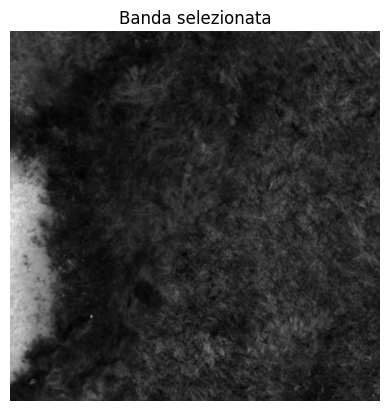

Seleziona una ROI sull'immagine.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


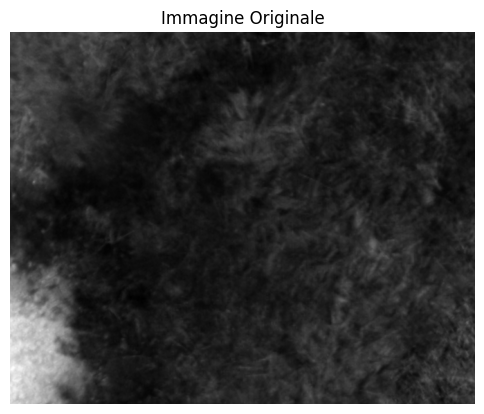

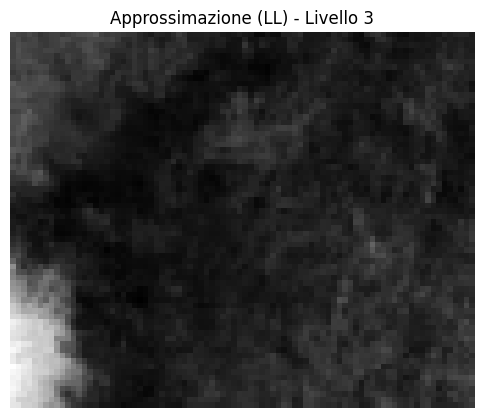

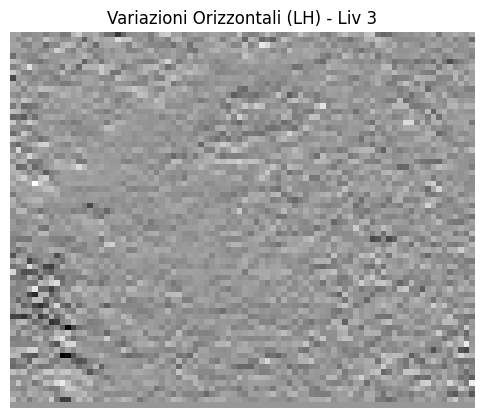

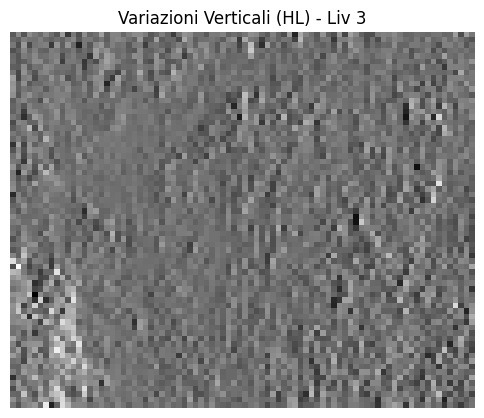

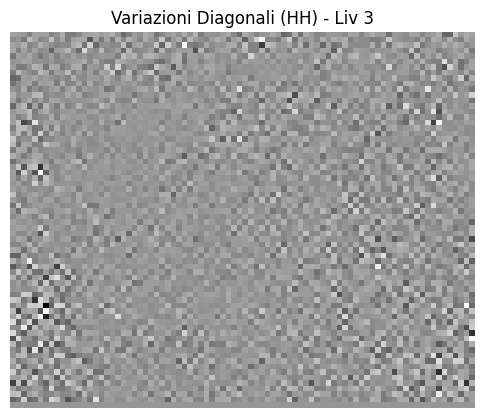

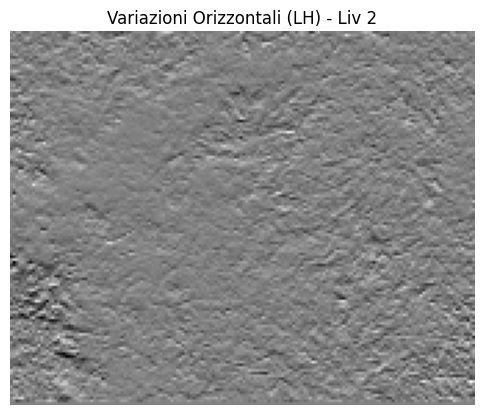

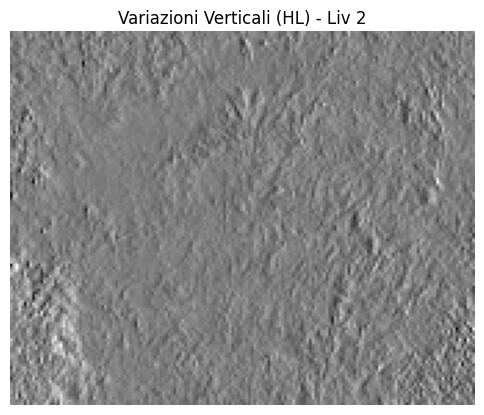

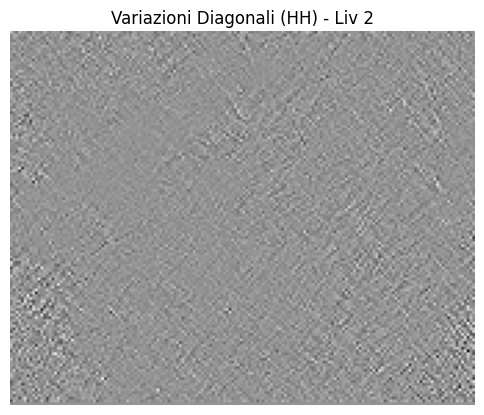

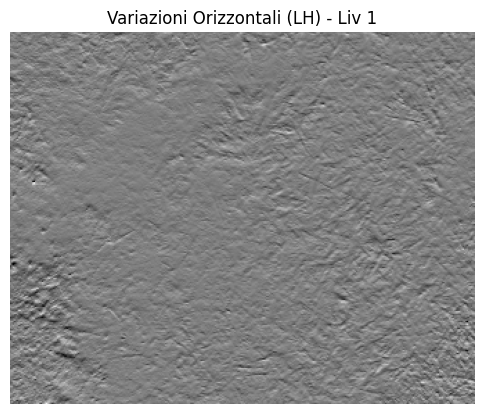

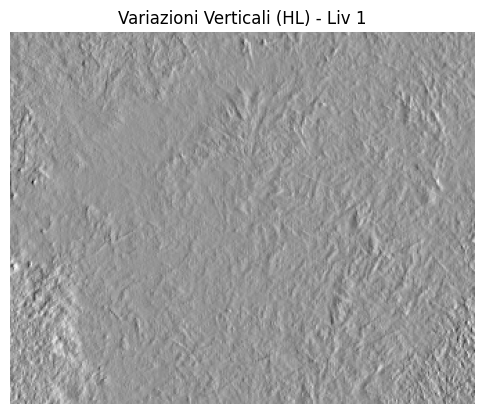

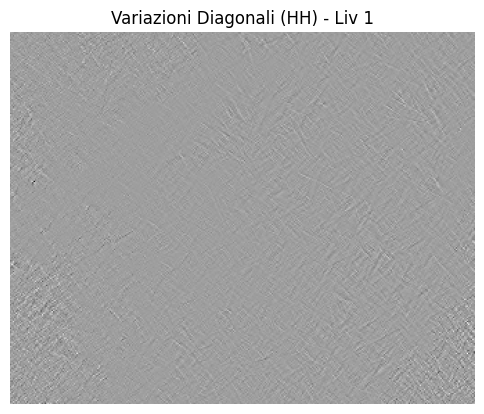

In [ ]:
import cv2
import pywt
import matplotlib.pyplot as plt
import tifffile as tiff
import os

# Carica l'immagine TIFF con 5 bande
image_path = '/home/brus/Projects/wavelet/channel_1/window_216.tif'
image5 = tiff.imread(image_path)

# Verifica dimensioni e canali
print(f"Dimensione immagine: {image5.shape}")  # E.g., (height, width, 5)

# Crea una directory per salvare i canali
output_dir = '/home/brus/Projects/wavelet/output_channels'
os.makedirs(output_dir, exist_ok=True)

selected_band= image5

# Visualizza la banda selezionata
plt.imshow(selected_band, cmap='gray')
plt.title('Banda selezionata')
plt.axis('off')
plt.show()

# --- Selezione ROI ---
print("Seleziona una ROI sull'immagine.")
roi = cv2.selectROI("Seleziona ROI", selected_band, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()  # Chiudi la finestra dopo la selezione

# Applica il crop all'immagine
x, y, w, h = roi
image = selected_band[y:y+h, x:x+w]

# --- Parametri ---
max_level = 3  # Numero massimo di livelli di decomposizione
wavelet = 'haar'  # Tipo di wavelet

# --- Trasformata wavelet fino al terzo livello ---
coeffs = pywt.wavedec2(image, wavelet=wavelet, level=max_level)
LL = coeffs[0]           # Coefficienti di approssimazione all'ultimo livello
details = coeffs[1:]     # Lista di tuple: (LH, HL, HH) per ogni livello

# --- Visualizzazione ---
# Visualizza l'immagine originale
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title("Immagine Originale")
plt.axis('off')
plt.show()

# Visualizza le approssimazioni all'ultimo livello
plt.figure(figsize=(6, 6))
plt.imshow(LL, cmap='gray')
plt.title(f"Approssimazione (LL) - Livello {max_level}")
plt.axis('off')
plt.show()

# Visualizza dettagli per ciascun livello
for i, (LH, HL, HH) in enumerate(details, start=1):
      level = max_level - i + 1

      plt.figure(figsize=(6, 6))
      plt.imshow(LH, cmap='gray')
      plt.title(f"Variazioni Orizzontali (LH) - Liv {level}")
      plt.axis('off')
      plt.show()

      plt.figure(figsize=(6, 6))
      plt.imshow(HL, cmap='gray')
      plt.title(f"Variazioni Verticali (HL) - Liv {level}")
      plt.axis('off')
      plt.show()

      plt.figure(figsize=(6, 6))
      plt.imshow(HH, cmap='gray')
      plt.title(f"Variazioni Diagonali (HH) - Liv {level}")
      plt.axis('off')
      plt.show()


## Wavelet Scattering traform

Dimensione immagine: (408, 612, 3)
Original image shape:  (408, 612)


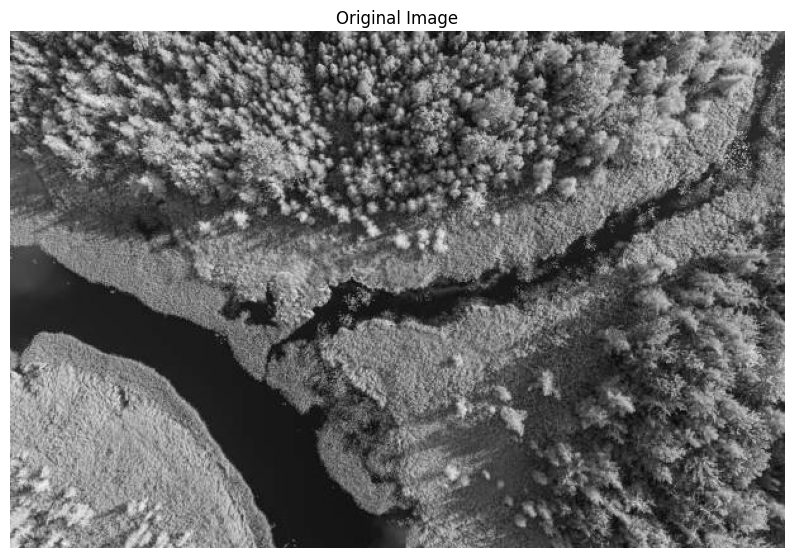

/tmp/ipykernel_550801/1425387597.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


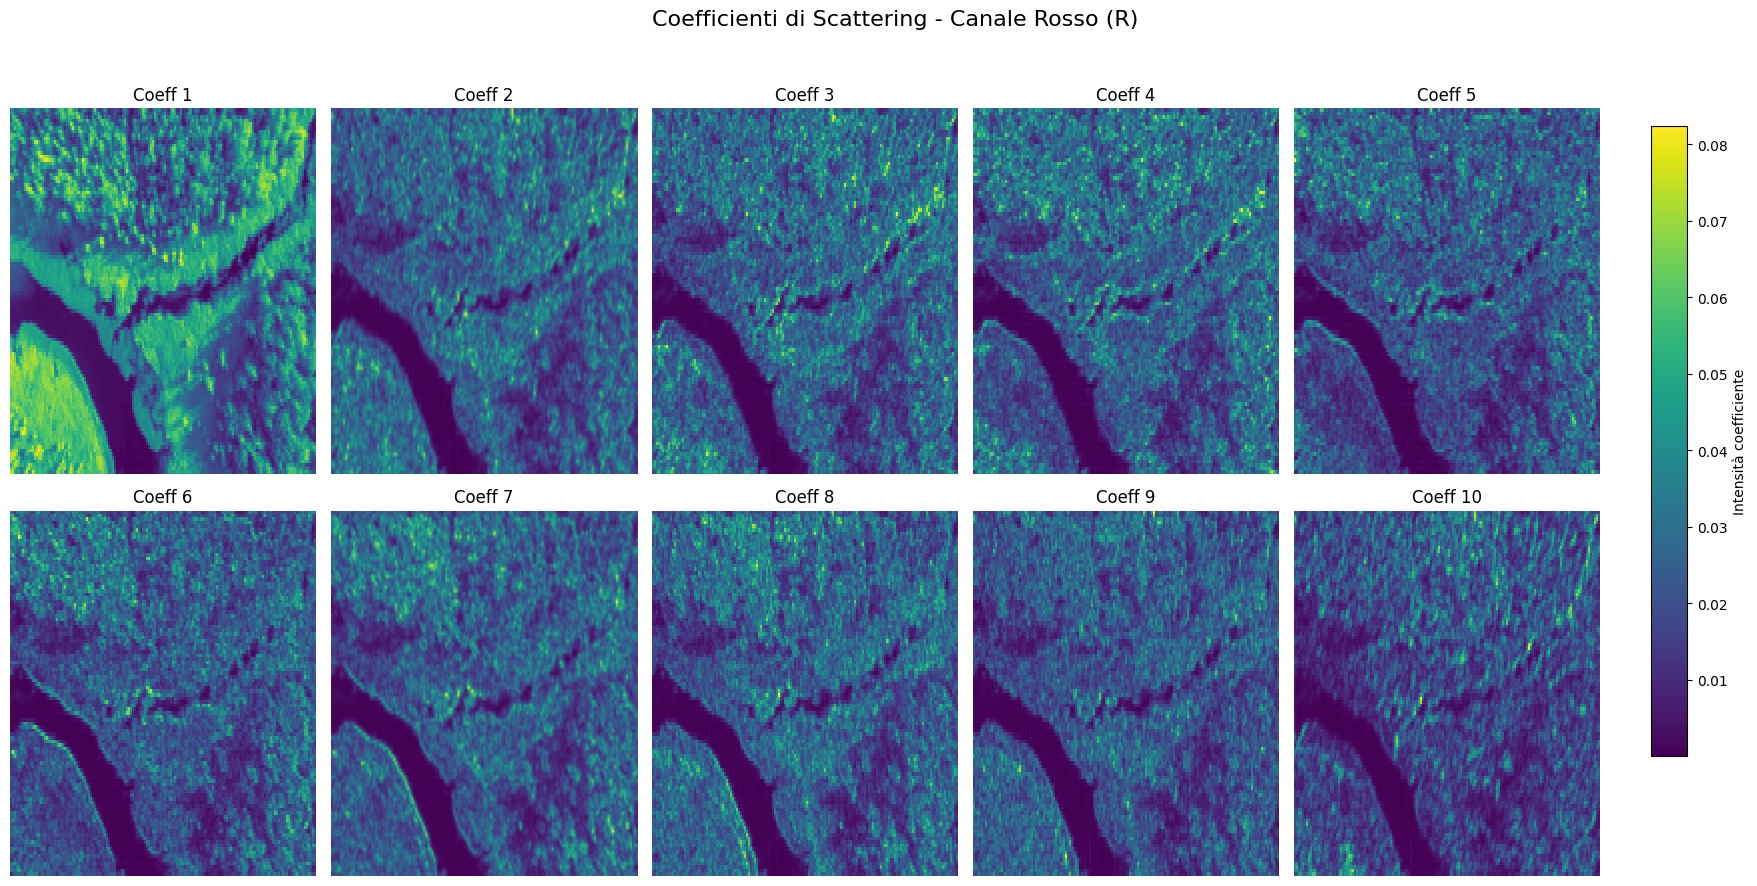

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kymatio.torch import Scattering2D
from PIL import Image

# Caricamento immagine
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255.0
    return img

# Definizione dei parametri per la Wavelet Scattering Transform
J = 2
L = 8

# Caricamento dell'immagine
image_path = "/home/brus/Scaricati/istockphoto-1409296017-612x612.jpg"
img = load_image(image_path)

# Dimensione dell'immagine
shape = img.shape
print(f"Dimensione immagine: {shape}")

# Creazione dell'oggetto Scattering2D
scattering = Scattering2D(J=J, L=L, shape=shape[:2])

# Calcolo dei coefficienti per il canale Green (G)
def compute_scattering_for_channel(img, channel_idx=1):
    img_channel = img[:, :, channel_idx]
    img_tensor = torch.from_numpy(img_channel).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    img_tensor = img_tensor.contiguous()

    # Computazione della trasformata wavelet scattering
    scattering_coeffs = scattering(img_tensor)
    return scattering_coeffs.squeeze().numpy()

scattering_coeffs = compute_scattering_for_channel(img, channel_idx=0)

# Visualizzazione migliorata dei coefficienti
def plot_scattering_coefficients(coeffs, J, L, img_name):
    """
    Visualizza i coefficienti di scattering per il canale selezionato.
    """
    
    # Display the original image before resizing
    original_img = Image.open(img_name).convert('L')
    print("Original image shape: ", np.array(original_img).shape)
    plt.figure(figsize=(10, 8))
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    num_coeffs = min(10, len(coeffs))  # Visualizza fino a 10 coefficienti
    fig, axes = plt.subplots(2, 5, figsize=(18, 9))

    for i in range(num_coeffs):
        ax = axes[i // 5, i % 5]
        im = ax.imshow(coeffs[i], cmap="viridis", aspect='auto')
        ax.axis("off")
        ax.set_title(f"Coeff {i+1}")

    # Aggiunta di una colorbar
    fig.suptitle("Coefficienti di Scattering - Canale Rosso (R)", fontsize=16)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Intensità coefficiente')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

# Visualizza i coefficienti
plot_scattering_coefficients(scattering_coeffs, J, L, image_path)


classifier


In [ ]:
import numpy as np
import tifffile as tiff
from kymatio import Scattering2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Carica l'immagine TIFF
image = tiff.imread('path_to_your_tiff_file.tif')

# Se l'immagine è multicanale, seleziona il primo canale
if len(image.shape) == 3:
    image = image[:, :, 0]

# Definisci i parametri per la trasformata wavelet scatter
J = 2  # Numero di scale
shape = image.shape

# Crea l'oggetto Scattering2D
scattering = Scattering2D(J=J, shape=shape)

# Applica la trasformata wavelet scatter
Sx = scattering(image)

# Appiattisci i coefficienti scatter per creare un vettore di caratteristiche
features = Sx.reshape(Sx.shape[0], -1)

# Crea etichette fittizie per la classificazione (sostituisci con le tue etichette reali)
# Qui assumiamo che ci siano due classi, 0 e 1
labels = np.random.randint(0, 2, size=(features.shape[0],))

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Crea e addestra un classificatore RandomForest
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# Fai previsioni sui dati di test
y_pred = classifier.predict(X_test)

# Calcola l'accuratezza del classificatore
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuratezza del classificatore: {accuracy:.2f}')

# Scattering disk display
This script reproduces the display of scattering coefficients amplitude within a disk as described in
"Invariant Scattering Convolution Networks" by J. Bruna and S. Mallat (2012) (https://arxiv.org/pdf/1203.1513.pdf).

img shape:  (32, 32)
coeffs shape:  (127, 4, 4)
nb of (order 1, order 2) coefficients:  (18, 108)
Original image shape:  (3648, 5472)


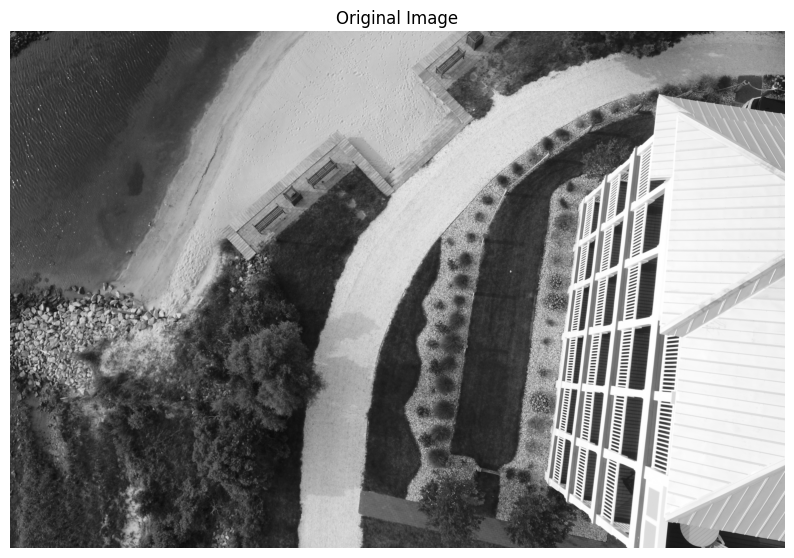

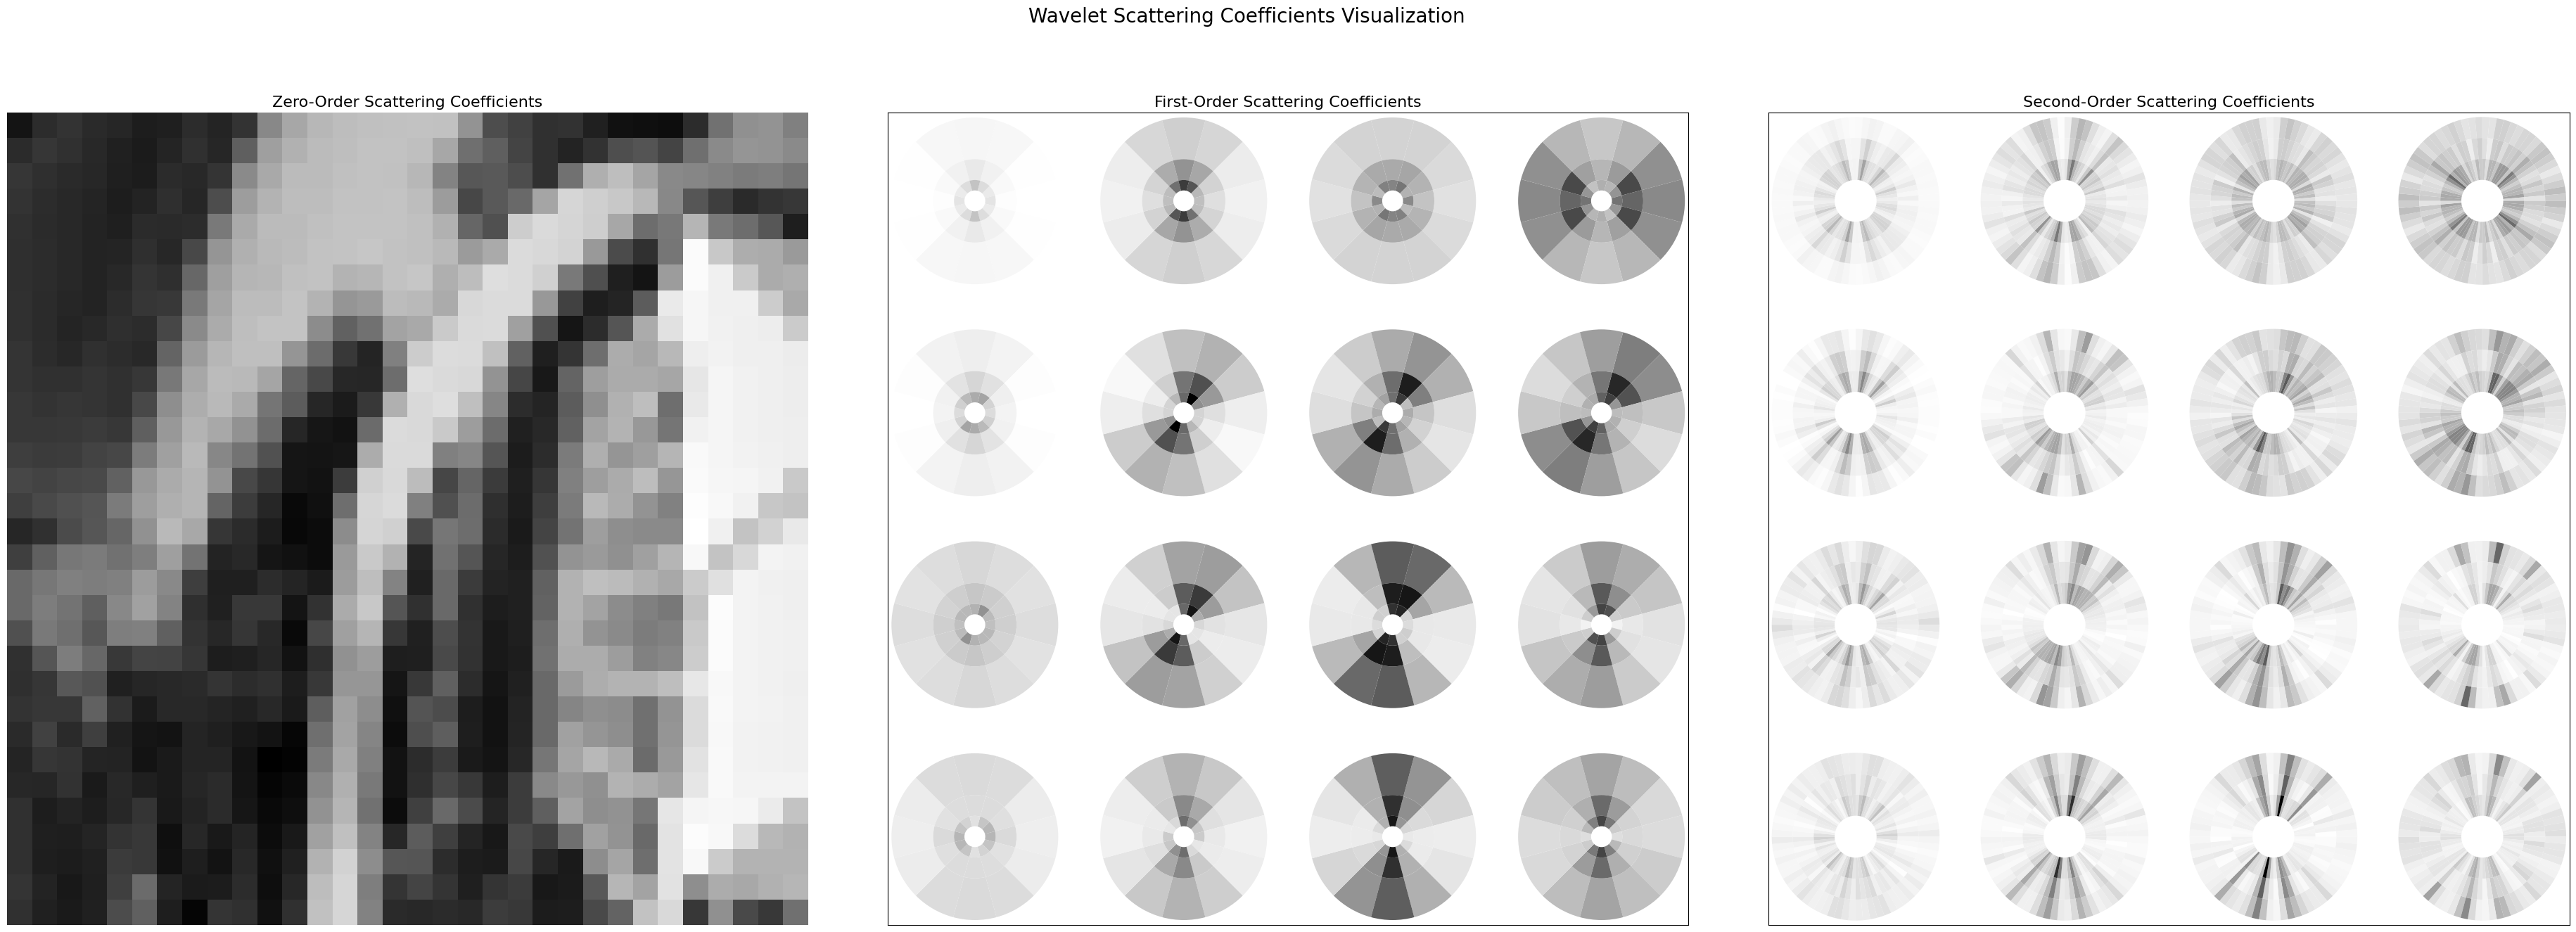

In [4]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from kymatio import Scattering2D
from PIL import Image
import os

img_name = os.path.join(os.getcwd(), "/home/brus/Projects/wavelet/results/DJI_0205.JPG")

src_img = Image.open(img_name).convert('L').resize((32, 32))
src_img = np.array(src_img)
print("img shape: ", src_img.shape)

L = 6
J = 3
scattering = Scattering2D(J=J, shape=src_img.shape, L=L, max_order=2, frontend='numpy')

src_img_tensor = src_img.astype(np.float32) / 255.

scat_coeffs = scattering(src_img_tensor)
print("coeffs shape: ", scat_coeffs.shape)
# Invert colors
scat_coeffs= -scat_coeffs

len_order_1 = J*L
scat_coeffs_order_1 = scat_coeffs[1:1+len_order_1, :, :]
norm_order_1 = mpl.colors.Normalize(scat_coeffs_order_1.min(), scat_coeffs_order_1.max(), clip=True)
mapper_order_1 = cm.ScalarMappable(norm=norm_order_1, cmap="gray")
# Mapper of coefficient amplitude to a grayscale color for visualisation.

len_order_2 = (J*(J-1)//2)*(L**2)
scat_coeffs_order_2 = scat_coeffs[1+len_order_1:, :, :]
norm_order_2 = mpl.colors.Normalize(scat_coeffs_order_2.min(), scat_coeffs_order_2.max(), clip=True)
mapper_order_2 = cm.ScalarMappable(norm=norm_order_2, cmap="gray")
# Mapper of coefficient amplitude to a grayscale color for visualisation.

# Retrieve spatial size
window_rows, window_columns = scat_coeffs.shape[1:]
print("nb of (order 1, order 2) coefficients: ", (len_order_1, len_order_2))

# Display the original image before resizing
original_img = Image.open(img_name).convert('L')
print("Original image shape: ", np.array(original_img).shape)
plt.figure(figsize=(10, 8))
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Define figure size and grid on which to plot input digit image, first-order and second-order scattering coefficients
fig = plt.figure(figsize=(47, 15))
spec = fig.add_gridspec(ncols=3, nrows=1)

gs = gridspec.GridSpec(1, 3, wspace=0.1)
gs_order_1 = gridspec.GridSpecFromSubplotSpec(window_rows, window_columns, subplot_spec=gs[1])
gs_order_2 = gridspec.GridSpecFromSubplotSpec(window_rows, window_columns, subplot_spec=gs[2])

# Add a title to the overall figure
fig.suptitle('Wavelet Scattering Coefficients Visualization', fontsize=20)

# Add titles for each column
ax1 = plt.subplot(gs[0])
ax1.set_title('Zero-Order Scattering Coefficients', fontsize=16)

ax2 = plt.subplot(gs[1])
ax2.set_title('First-Order Scattering Coefficients', fontsize=16)

ax3 = plt.subplot(gs[2])
ax3.set_title('Second-Order Scattering Coefficients', fontsize=16)

# Start by plotting input image and invert colors
ax = plt.subplot(gs[0])
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(src_img,cmap='gray',interpolation='nearest', aspect='auto')
ax.axis('off')

# Plot first-order scattering coefficients
ax = plt.subplot(gs[1])
ax.set_xticks([])
ax.set_yticks([])

l_offset = int(L - L / 2 - 1)  # follow same ordering as Kymatio for angles

for row in range(window_rows):
    for column in range(window_columns):
        ax = fig.add_subplot(gs_order_1[row, column], projection='polar')
        ax.axis('off')
        coefficients = scat_coeffs_order_1[:, row, column]
        for j in range(J):
            for l in range(L):
                coeff = coefficients[l + j * L]
                color = mapper_order_1.to_rgba(coeff)
                angle = (l_offset - l) * np.pi / L
                radius = 2 ** (-j - 1)
                ax.bar(x=angle,
                       height=radius,
                       width=np.pi / L,
                       bottom=radius,
                       color=color)
                ax.bar(x=angle + np.pi,
                       height=radius,
                       width=np.pi / L,
                       bottom=radius,
                       color=color)

# Plot second-order scattering coefficients
ax = plt.subplot(gs[2])
ax.set_xticks([])
ax.set_yticks([])

for row in range(window_rows):
    for column in range(window_columns):
        ax = fig.add_subplot(gs_order_2[row, column], projection='polar')
        ax.axis('off')
        coefficients = scat_coeffs_order_2[:, row, column]
        for j1 in range(J - 1):
            for j2 in range(j1 + 1, J):
                for l1 in range(L):
                    for l2 in range(L):
                        coeff_index = l1 * L * (J - j1 - 1) + l2 + L * (j2 - j1 - 1) + (L ** 2) * \
                                      (j1 * (J - 1) - j1 * (j1 - 1) // 2)
                        # indexing a bit complex which follows the order used by Kymatio to compute
                        # scattering coefficients
                        coeff = coefficients[coeff_index]
                        color = mapper_order_2.to_rgba(coeff)
                        # split along angles first-order quadrants in L quadrants, using same ordering
                        # as Kymatio (clockwise) and center (with the 0.5 offset)
                        angle = (l_offset - l1) * np.pi / L + (L // 2 - l2 - 0.5) * np.pi / (L ** 2)
                        radius = 2 ** (-j1 - 1)
                        # equal split along radius is performed through height variable
                        ax.bar(x=angle,
                               height=radius / 2 ** (J - 2 - j1),
                               width=np.pi / L ** 2,
                               bottom=radius + (radius / 2 ** (J - 2 - j1)) * (J - j2 - 1),
                               color=color)
                        ax.bar(x=angle + np.pi,
                               height=radius / 2 ** (J - 2 - j1),
                               width=np.pi / L ** 2,
                               bottom=radius + (radius / 2 ** (J - 2 - j1)) * (J - j2 - 1),
                               color=color)

# Dataset wavelet analysis


In [ ]:
from wavelet_lib.analyzer import WSTDatasetAnalyzer

def main():
    # Configurazione
    pickle_path = "/home/brus/Projects/wavelet/datasets/processed_datasets/processed_tile_dataset.pkl"
    save_dir = "dataset_analysis"
    
    # Inizializza e usa l'analizzatore
    analyzer = WSTDatasetAnalyzer(pickle_path, save_dir)
    
    # Esegui l'analisi
    results = analyzer.analyze()
    
    # Crea i grafici
    analyzer.plot_analysis()
    
    # Ottieni le statistiche per l'uso in altri moduli
    stats = analyzer.get_dataset_stats()
    print("\nStatistiche del dataset per l'uso in altri moduli:")
    for key, value in stats.items():
        print(f"• {key}: {value}")
    
    print(f"\nAnalisi completata. Risultati salvati in: {save_dir}")

if __name__ == "__main__":
    main()

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from pathlib import Path

def load_wst_dataset(pickle_path):
    """Carica il dataset dal file pickle"""
    print(f"Caricamento dataset da: {pickle_path}")
    with open(pickle_path, 'rb') as f:
        return pickle.load(f)

def analyze_dataset(dataset):
    """Analizza e mostra le informazioni principali del dataset"""
    print("\n" + "="*50)
    print("ANALISI DATASET WST")
    print("="*50)

    # 1. Informazioni Generali
    print("\n1. INFORMAZIONI GENERALI:")
    print(f"• Numero totale campioni: {len(dataset['samples'])}")
    print(f"• Numero di classi: {len(dataset['classes'])}")
    print(f"• Classi disponibili: {dataset['classes']}")

    # 2. Distribuzione delle Classi
    class_distribution = Counter([label for _, label in dataset['samples']])
    print("\n2. DISTRIBUZIONE DELLE CLASSI:")
    for class_name in dataset['classes']:
        class_idx = dataset['class_to_idx'][class_name]
        count = class_distribution[class_idx]
        percentage = (count / len(dataset['samples'])) * 100
        print(f"• {class_name}: {count} campioni ({percentage:.1f}%)")

    # 3. Analisi Rappresentazioni Wavelet
    print("\n3. ANALISI RAPPRESENTAZIONI WAVELET:")
    sample_path = list(dataset['wavelet_representations'].keys())[0]
    sample_repr = dataset['wavelet_representations'][sample_path]
    print(f"• Shape rappresentazione: {sample_repr.shape}")
    print(f"• Tipo dati: {sample_repr.dtype}")
    print(f"• Range valori: [{sample_repr.min():.3f}, {sample_repr.max():.3f}]")
    print(f"• Media: {sample_repr.mean():.3f}")
    print(f"• Deviazione standard: {sample_repr.std():.3f}")

    return {
        'class_distribution': class_distribution,
        'sample_repr': sample_repr,
        'classes': dataset['classes']
    }

def plot_dataset_info(analysis_results, save_dir=None):
    """Crea e salva i grafici delle analisi"""
    # 1. Distribuzione delle Classi
    plt.figure(figsize=(12, 6))
    classes = analysis_results['classes']
    counts = [analysis_results['class_distribution'][i] for i in range(len(classes))]
    
    sns.barplot(x=classes, y=counts)
    plt.title('Distribuzione delle Classi nel Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Numero di Campioni')
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'class_distribution.png'))
    plt.close()

    # 2. Heatmap della Prima Rappresentazione Wavelet
    sample_repr = analysis_results['sample_repr']
    
    # Plot separate heatmaps for each channel
    for channel in range(3):
        plt.figure(figsize=(10, 8))
        # Take the first slice of the channel dimension and convert to numpy
        channel_data = sample_repr[channel, 0].cpu().numpy()
        sns.heatmap(channel_data, cmap='viridis')
        plt.title(f'Heatmap Rappresentazione Wavelet - Canale {channel}')
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'wavelet_heatmap_channel_{channel}.png'))
        plt.close()

def main():
    # Configurazione
    pickle_path = "/home/brus/Projects/wavelet/datasets/HPL_images/custom_datasets_WST/processed_tile_dataset_4_classes.pkl"
    save_dir = "dataset_analysis"

    # Crea directory per i risultati
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Carica e analizza il dataset
    dataset = load_wst_dataset(pickle_path)
    analysis_results = analyze_dataset(dataset)

    # Crea e salva i grafici
    plot_dataset_info(analysis_results, save_dir)
    
    print(f"\nAnalisi completata. Risultati salvati in: {save_dir}")

if __name__ == "__main__":
    main()
